# Gaussian Density Filtering for predicting mid price raise in LOBs

In this notebook we present results of prediction if the mid price of LOB will raise in next tick. For data preparation we use GDF filters with various parameters `r` and `s`.

For prediction we use SVM - we will use 4 features for predictions, which will be described in later parts.

This notebook contains information which parameters for GDF and SVM were the best.

In [1]:
%matplotlib inline
from ast import literal_eval
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from typing import Tuple
import numpy as np
import itertools
import os

from sklearn import preprocessing
from sklearn.metrics import roc_auc_score
from scipy.stats import norm

import plotly.offline as py
import plotly.figure_factory as ff
import plotly.graph_objs as go

import warnings

from lob_data_utils import lob, db_result, roc_results

sns.set_style('whitegrid')
warnings.filterwarnings('ignore')
py.init_notebook_mode(connected=True)

## Data

We use data from 2013-09 till 2013-11 from 53 stocks which have at least 10000 datapoints - we use exactly 10000 datapoints. First we normalize the data, then we apply GDF filters (described in `gdf_approach_description.ipynb` notebook). For GDF filters we need to choose parameters:

* $\sigma$ - how wide is the Gaussian curve
* $r$ - how tall is the Gaussian curve
* $K$ - on how many segments we will divide the data

We have choosen:
* $\sigma \in \{0.1, 0.2, 0.3, 0.4, 0.5\} $
* $r \in \{ 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 \}$
* K = 50

We used grid approach, so we generated the data for every pair of the parameters $r$ and $\sigma$.

We split data into three continous datasets:
* training data - 60% of datapoints
* validation data - 20% of datapoints
* testing data - 20% of datapoints

In [76]:
r = 0.05
s = 0.2
stock = '11234'
K = 50
length = 10000
filename = 'data_gdf/gdf_{}_len{}_r{}_s{}_K{}.csv'.format(stock, length, r, s, K)
df_data_example = pd.read_csv(filename)
df_data_example.head()

,Unnamed: 0,gdf_0,gdf_1,gdf_10,gdf_11,gdf_12,gdf_13,gdf_14,gdf_15,gdf_16,...,gdf_47,gdf_48,gdf_49,gdf_5,gdf_6,gdf_7,gdf_8,gdf_9,mid_price,mid_price_indicator
0,0,0.044717,0.042422,0.039359,0.020774,0.017821,0.031134,0.037212,0.036937,0.036890,...,0.022216,0.042422,0.068645,0.043469,0.043135,0.043079,0.043095,0.043245,1126.0,1.0
1,1,0.038236,0.041373,0.055072,0.054940,0.054930,0.054995,0.051482,0.027327,0.014260,...,0.064003,0.064166,0.038236,0.041554,0.029651,0.017502,0.021706,0.041345,1126.5,0.0
2,2,0.049813,0.042422,0.039359,0.020774,0.017821,0.031134,0.042903,0.042628,0.042581,...,0.022216,0.042422,0.059669,0.043435,0.043101,0.043046,0.043061,0.043211,1126.0,0.0
3,3,0.038713,0.051725,0.020990,0.020864,0.020854,0.020920,0.021303,0.022940,0.017034,...,0.068332,0.067075,0.038713,0.051923,0.029244,0.017364,0.021819,0.021642,1125.5,1.0
4,4,0.048388,0.042422,0.039359,0.020774,0.017821,0.031134,0.039622,0.039347,0.039300,...,0.022216,0.042422,0.058017,0.044250,0.043916,0.043861,0.043876,0.044026,1126.0,1.0


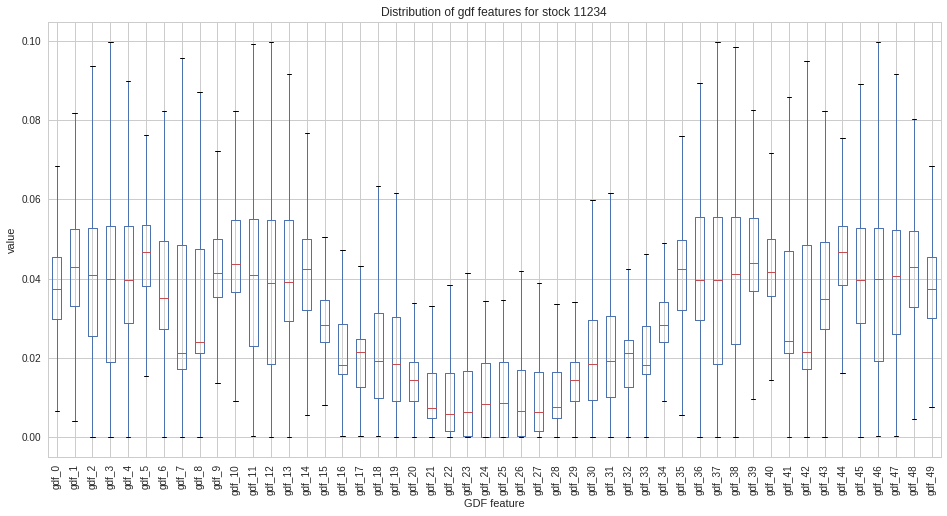

In [77]:
gdf_columns = ['gdf_' + str(i) for i in range(0, 50)]
df_data_example[gdf_columns].plot(kind='box', figsize=(16,8),  rot=90)
plt.title('Distribution of gdf features for stock ' + stock)
plt.xlabel('GDF feature')
plt.ylabel('value')

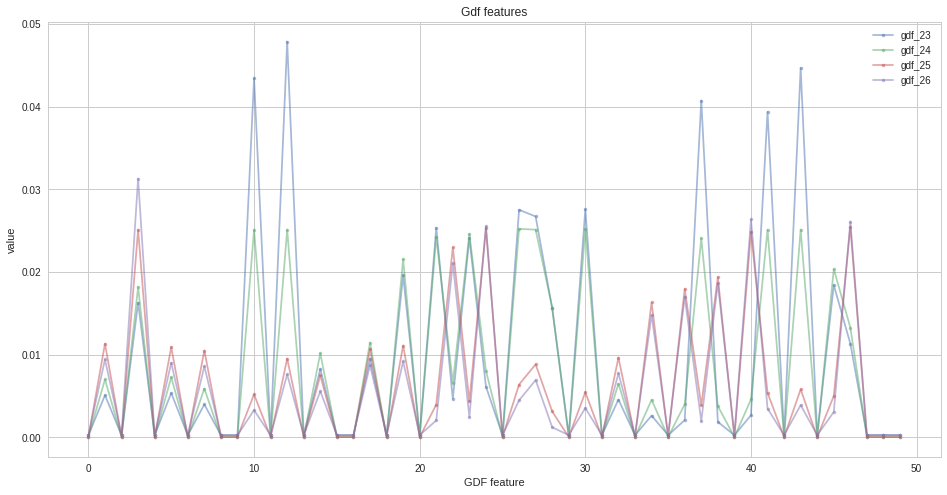

In [78]:
gdf_features_columns = ['gdf_' + str(i) for i in range(23, 27)]
df_data_example[gdf_features_columns].iloc[0:50].plot(figsize=(16,8), marker='.', alpha=0.5)
plt.title('Gdf features')
plt.xlabel('GDF feature')
plt.ylabel('value')

## Results

We train SVM with `rbf` kernel on *training* dataset. Next we hypertune `gamma` and `C` parameters on *validation* dataset. After that we pick the best parameters for training algorithm and test how it performs on *testing* dataset.

In this notebook we pick 4 features for prediction:
* gdf_23
* gdf_24
* gdf_25
* gdf_26

obtained by applying GDF filters to the datasets. They are choosen, because they don't have so wide spread of values as the rest and they are in the "middle".

For choosing the SVM parameters we will use grid-search approach with parameters:
* $\gamma \in (1, 10, 100, 1000, 10000)$
* $ C \in (1, 10, 100, 1000, 10000)$
                
We will use ROC area score for evaluating the performance of the classifiers.

In [2]:
s_paramters = [0.1, 0.2, 0.3, 0.4, 0.5]
r_paramters = [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1]
length = 10000
stocks = list(roc_results.results_10000.keys())
K1 = 23
K2 = 27
K = 50

df_res = pd.DataFrame()
for r in r_parameters:
    for s in s_paramters:
        for stock in stocks:
            try:
                filename = 'data_res/res_{}_len{}_r{}_s{}_K{}-{}.csv'.format(stock, length, r, s, K1, K2)
                df = pd.read_csv(filename)
                df_res = df_res.append(df, ignore_index=True)
            except Exception as e:
                pass
df_res.drop('Unnamed: 0', axis=1, inplace=True)
df_res = df_res.apply(pd.to_numeric)
df_res.dropna(axis=0, inplace=True)
df_res.head()

,C,K,gamma,r,roc_cv,roc_train,s,stock
1,1,50,10,0.01,0.504764,0.588741,0.1,9069
2,1,50,100,0.01,0.507346,0.545191,0.1,9069
3,1,50,1000,0.01,0.522823,0.545723,0.1,9069
4,1,50,10000,0.01,0.538933,0.558268,0.1,9069
5,10,50,1,0.01,0.504764,0.589502,0.1,9069


In [3]:
print('Number of stocks:', len(df_res['stock'].unique()))

53


#### Results dataset

We introduce dataframe with results which will have columns:
* `stock` - stock id
* `K` - number of segments for GDF filters
* `s` - $\sigma$ parameter for GDF filters
* `r` - scale parameter for GDF filters
* `C` - C parameter for SVM
* `gamma` - $\gamma$ parameter for SVM
* `roc_cv` - ROC area score for SVM(C, gamma) on validation set
* `roc_train` - ROC area score for SVM(C, gamma) on training set
* `roc_log_cv` - ROC area score for logistic regression on validation set
* `roc_log_train` - ROC area score for logistic regression on training set

In [4]:
df_res['roc_log_cv'] = np.zeros(len(df_res)) - 1
df_res['roc_log_train'] = np.zeros(len(df_res)) - 1
roc_log_cv = []
res_log = roc_results.result_cv_10000
for idx, row in df_res.iterrows():
    roc_log_cv.append(res_log[str(int(row['stock']))])
df_res['roc_log_cv'] = roc_log_cv

roc_log_train = []
res_log = roc_results.results_10000
for idx, row in df_res.iterrows():
    roc_log_train.append(res_log[str(int(row['stock']))])
df_res['roc_log_train'] = roc_log_train

df_res.head()

,C,K,gamma,r,roc_cv,roc_train,s,stock,roc_log_cv,roc_log_train
1,1,50,10,0.01,0.504764,0.588741,0.1,9069,0.546371,0.538344
2,1,50,100,0.01,0.507346,0.545191,0.1,9069,0.546371,0.538344
3,1,50,1000,0.01,0.522823,0.545723,0.1,9069,0.546371,0.538344
4,1,50,10000,0.01,0.538933,0.558268,0.1,9069,0.546371,0.538344
5,10,50,1,0.01,0.504764,0.589502,0.1,9069,0.546371,0.538344


### Results on training and validation set

If we pick the best ROC area scores we calculated, we get too good scores on training and validation set. There is no connection between trainig and validation set scores - one can be very high, when the corresponding one can be less than 0.5. It means that this approach is prone to **overfitting** and we need to be careful with choosing parameters.

We don't take into account results for which ROC area score on validation set was better by more than 0.1 than on training set.

In [5]:
df_res['cv_train_diff'] = df_res['roc_cv'] - df_res['roc_train']
df_bests = df_res.sort_values(by='roc_cv', ascending=False)

df_bests = df_bests.groupby(by='stock').first()
df_bests = df_bests[df_bests['cv_train_diff'] < 0.15].sort_values(by='roc_cv')
df_bests.head()

,C,K,gamma,r,roc_cv,roc_train,s,roc_log_cv,roc_log_train,cv_train_diff
stock,,,,,,,,,,
9062,100,50,100,0.01,0.542794,0.540283,0.1,0.552745,0.533872,0.002511
9266,10000,50,1000,0.01,0.558663,0.543182,0.4,0.550025,0.543751,0.015481
12456,10000,50,1,0.07,0.573204,0.542968,0.3,0.544916,0.559657,0.030236
9058,1,50,10,0.09,0.589505,0.551085,0.5,0.535500,0.547275,0.038419
9761,10,50,1,0.09,0.607909,0.577440,0.3,0.565315,0.552698,0.030469


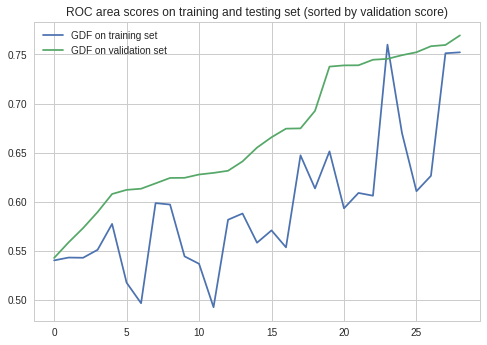

In [6]:
dff = df_bests[['roc_train', 'roc_cv']].sort_values(by='roc_cv')
dff = dff.sort_values(by='roc_cv')

plt.plot(dff['roc_train'].values, label='GDF on training set')

plt.plot(dff['roc_cv'].values, label='GDF on validation set')

plt.legend()
plt.title('ROC area scores on training and testing set (sorted by validation score)')

### Results on training set - GDF vs logistic regression

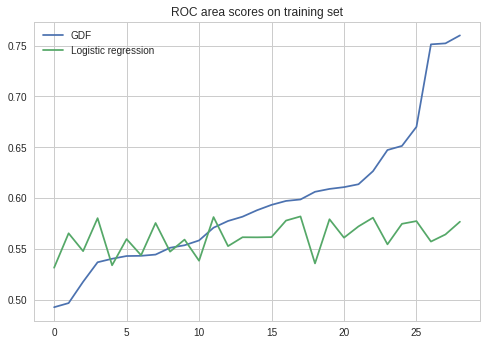

In [7]:
dff = df_bests[['roc_train', 'roc_log_train']].sort_values(by='roc_train')

plt.plot(dff.sort_values(by='roc_train')['roc_train'].values, label='GDF')
plt.plot(dff.sort_values(by='roc_train')['roc_log_train'].values, label='Logistic regression')

plt.legend()
plt.title('ROC area scores on training set')

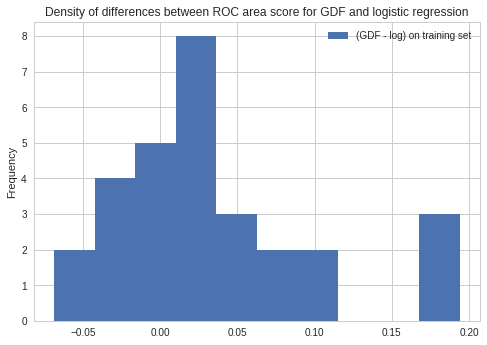

In [8]:
dff['gdf_log_train_diff'] = dff['roc_train'] - dff['roc_log_train']
dff['gdf_log_train_diff'].plot(kind='hist', label='(GDF - log) on training set')
plt.legend()
plt.title('Density of differences between ROC area score for GDF and logistic regression')

In [9]:
all_stocks = set(df_bests.index)
print('len all stocks', len(all_stocks))
better_stocks = set((df_bests[df_bests['roc_train'] > df_bests['roc_log_train']].index.unique()))
print('number of worse stocks on training set:', len(all_stocks - better_stocks))
for stock in (all_stocks - better_stocks):
    print(stock)
    print(df_bests.loc[stock][['roc_train', 'roc_log_train']])

len all stocks 29
number of worse stocks: 9
4549
roc_train        0.544393
roc_log_train    0.575461
Name: 4549, dtype: float64
3879
roc_train        0.536841
roc_log_train    0.580233
Name: 3879, dtype: float64
12456
roc_train        0.542968
roc_log_train    0.559657
Name: 12456, dtype: float64
10887
roc_train        0.496671
roc_log_train    0.565330
Name: 10887, dtype: float64
11946
roc_train        0.570844
roc_log_train    0.581297
Name: 11946, dtype: float64
5836
roc_train        0.553565
roc_log_train    0.559133
Name: 5836, dtype: float64
11244
roc_train        0.492618
roc_log_train    0.531468
Name: 11244, dtype: float64
9266
roc_train        0.543182
roc_log_train    0.543751
Name: 9266, dtype: float64
11583
roc_train        0.517632
roc_log_train    0.547780
Name: 11583, dtype: float64


### Restuls on validation set - GDF vs logistic regression

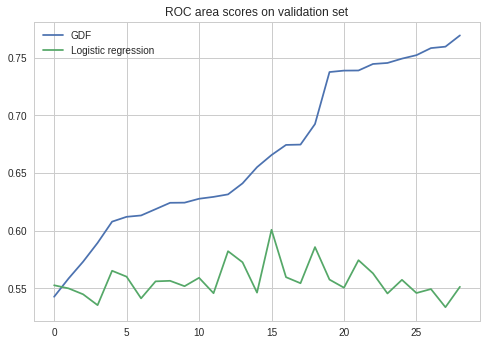

In [10]:
dff = df_bests[['roc_cv', 'roc_log_cv']].sort_values(by='roc_cv')

plt.plot(dff['roc_cv'].values, label='GDF')
plt.plot(dff['roc_log_cv'].values, label='Logistic regression')

plt.legend()
plt.title('ROC area scores on validation set')

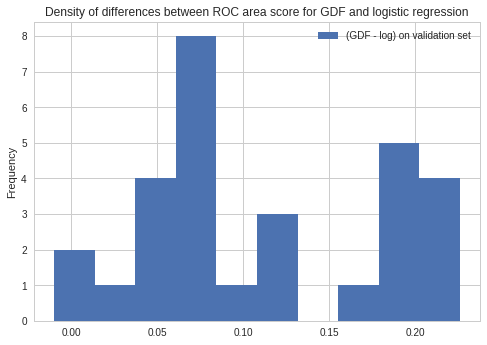

In [11]:
dff['gdf_log_cv_diff'] = dff['roc_cv'] - dff['roc_log_cv']
dff['gdf_log_cv_diff'].plot(kind='hist', label='(GDF - log) on validation set')
plt.legend()
plt.title('Density of differences between ROC area score for GDF and logistic regression')

In [12]:
all_stocks = set(df_bests.index)
print('len all stocks', len(all_stocks))
better_stocks = set((df_bests[df_bests['roc_cv'] > df_bests['roc_log_cv']].index.unique()))
print('number of worse stocks:', len(all_stocks - better_stocks))
for stock in (all_stocks - better_stocks):
    print(stock)
    print(df_bests.loc[stock][['roc_cv', 'roc_log_cv']])

len all stocks 29
number of worse stocks: 1
9062
roc_cv        0.542794
roc_log_cv    0.552745
Name: 9062, dtype: float64


### Tunning of `r` and `s` parameters for filters

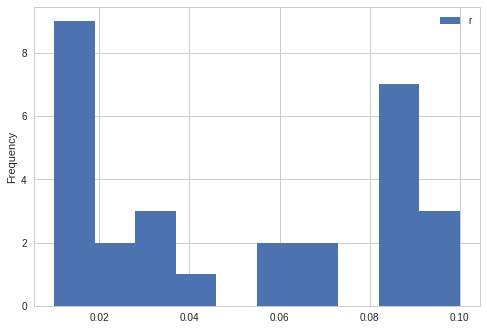

In [13]:
df_bests[['r']].plot(kind='hist')

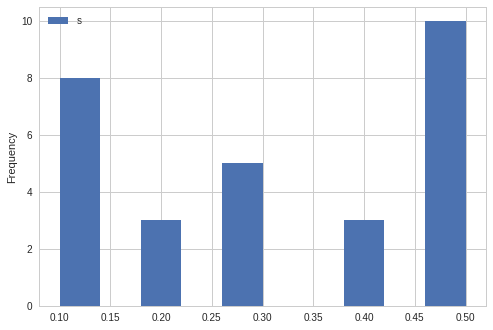

In [14]:
df_bests[['s']].plot(kind='hist')

### SVM hyperparameter tunnig (`gamma` and `C`)

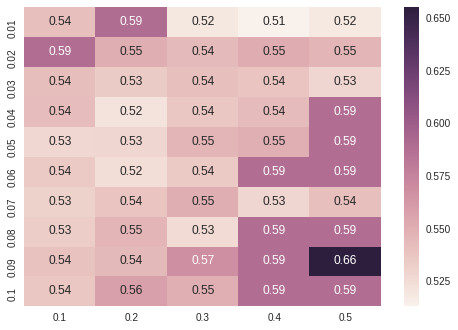

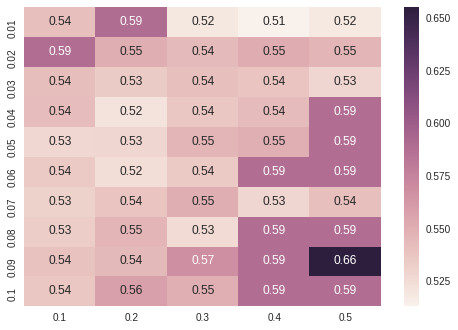

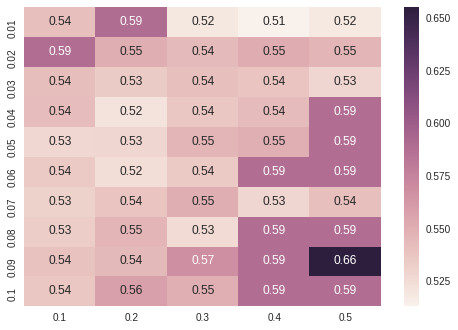

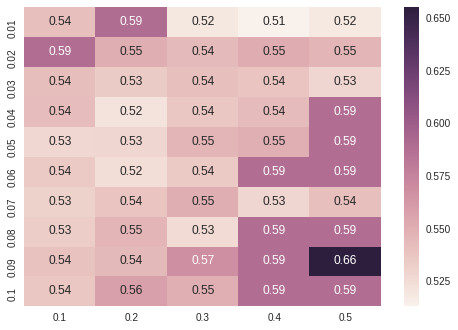

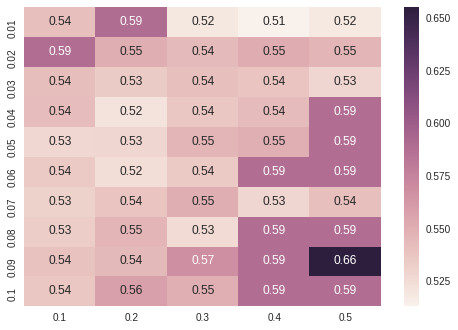

In [15]:
for s in df_res['stock'].values[0:5]:
    df_g = pd.DataFrame(index=rr, columns=ss)
    for i, row in df_res[df_res['stock'] == int(s)].groupby(['r', 's']).max().iterrows():
        if not np.isnan(row['roc_cv']):
            df_g.loc[i[0]][i[1]] = row['roc_cv']
    df_g = df_g.apply(pd.to_numeric)      
    sns.heatmap(df_g, annot=True)
    plt.title(s)
    plt.figure()

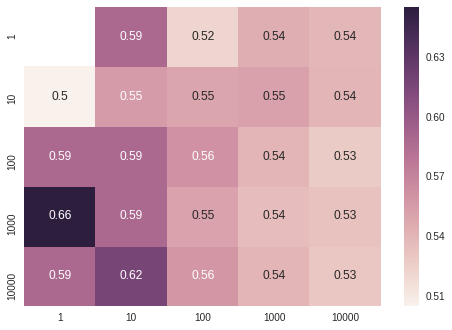

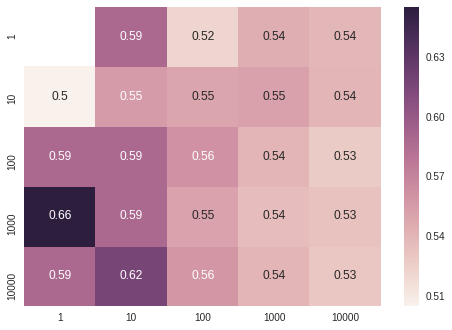

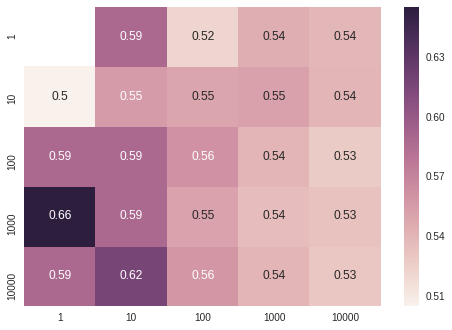

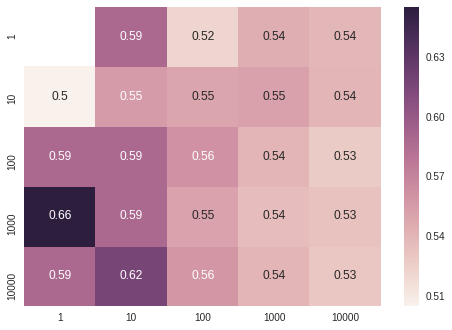

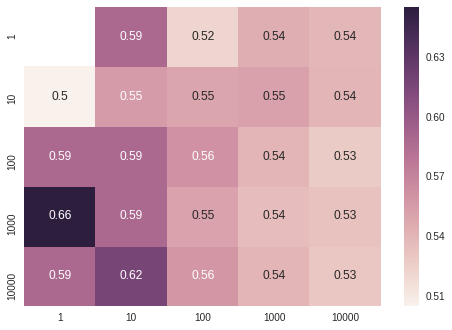

In [16]:
for s in df_res['stock'].values[0:5]:
    df_g = pd.DataFrame(index=sorted(df_res['C'].unique()), columns=sorted(df_res['gamma'].unique()))
    for i, row in df_res[df_res['stock'] == int(s)].groupby(['C', 'gamma']).max().iterrows():
        if not np.isnan(row['roc_cv']):
            df_g.loc[i[0]][i[1]] = row['roc_cv']
    df_g = df_g.apply(pd.to_numeric)      
    sns.heatmap(df_g, annot=True)
    plt.figure()

### All



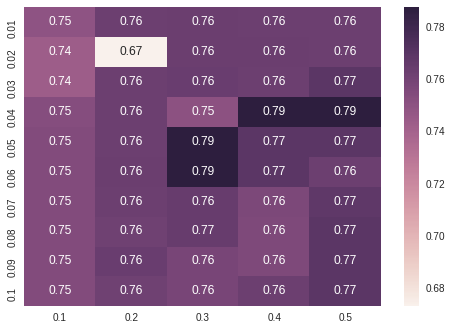

In [17]:
df_res = df_res.sort_values(by='roc_cv', ascending=False)
df_g = pd.DataFrame(index=rr, columns=ss)
for i, row in df_res.groupby(['r', 's']).max().iterrows():
    if not np.isnan(row['roc_cv']):
        df_g.loc[i[0]][i[1]] = row['roc_cv']
df_g = df_g.apply(pd.to_numeric)      
sns.heatmap(df_g, annot=True)
plt.figure()

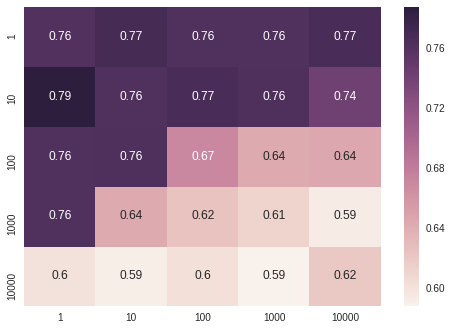

In [18]:
df_res = df_res.sort_values(by='roc_cv', ascending=False)
df_g = pd.DataFrame(index=sorted(df_res['C'].unique()), columns=sorted(df_res['gamma'].unique()))
for i, row in df_res.groupby(['gamma', 'C']).first().iterrows():
    if not np.isnan(row['roc_cv']):
        df_g.loc[i[0]][i[1]] = row['roc_cv']
df_g = df_g.apply(pd.to_numeric)      
sns.heatmap(df_g, annot=True)
plt.figure()

In [19]:
df_res[df_res['stock'] == 9061].sort_values(by='cv_train_diff', ascending=False)

,C,K,gamma,r,roc_cv,roc_train,s,stock,roc_log_cv,roc_log_train,cv_train_diff
41231,10,50,10,0.07,0.742743,0.422840,0.2,9061,0.528266,0.557542,0.319903
34610,100,50,1,0.06,0.742743,0.443675,0.2,9061,0.528266,0.557542,0.299068
41240,1000,50,1,0.07,0.742743,0.456214,0.2,9061,0.528266,0.557542,0.286529
55811,100,50,10,0.09,0.742986,0.506267,0.3,9061,0.528266,0.557542,0.236719
55802,1,50,100,0.09,0.742864,0.506263,0.3,9061,0.528266,0.557542,0.236602
55820,10000,50,1,0.09,0.742864,0.506267,0.3,9061,0.528266,0.557542,0.236598
49177,1,50,100,0.08,0.742743,0.506265,0.3,9061,0.528266,0.557542,0.236478
16065,1000,50,1,0.03,0.742621,0.506260,0.3,9061,0.528266,0.557542,0.236361
62436,100,50,10,0.10,0.742864,0.525536,0.3,9061,0.528266,0.557542,0.217328
57141,1000,50,10,0.09,0.742743,0.525536,0.4,9061,0.528266,0.557542,0.217207


## Learning curves

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.datasets import load_digits
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit


def plot_learning_curve(estimator, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring='roc_auc')
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

def read_gdf_data(stock, r, s, K=50, length=10000):
    filename = 'gdf_{}_len{}_r{}_s{}_K{}'.format(stock, length, r, s, K)
    if not os.path.exists(os.path.join('data_gdf',  filename + '.csv')):
        print('GDF file ', filename, 'does not exist')
    try:
        dfs, dfs_cv, dfs_test = lob.load_prepared_data(
            filename, data_dir='data_gdf/', cv=True, length=length)
        if dfs is None:
            print('none')
    except Exception as e:
        print(filename, 'not read', e)
    return dfs, dfs_cv, dfs_test

def plot_svm_learning_curve(df, C=1000, gamma=1):
    clf = SVC(kernel='rbf', C=C, gamma=gamma)
    gdf_columns = ['gdf_' + str(i) for i in range(0, 50)][K1:K2]
    X = df.loc[:, gdf_columns]
    y = df[['mid_price_indicator']].values
    c, r = y.shape
    y = y.reshape(c, )
    y[0] = 0
    clf.fit(X, y)
    plot_learning_curve(clf, X, y)
    return clf

In [21]:
df_overfit = df_bests[df_bests['roc_cv'] > df_bests['roc_train']].sort_values(by='roc_cv', ascending=False)
df_overfit['diff_cv_train'] = df_overfit['roc_cv'] - df_overfit['roc_train']

df_overfit.head()

,C,K,gamma,r,roc_cv,roc_train,s,roc_log_cv,roc_log_train,cv_train_diff,diff_cv_train
stock,,,,,,,,,,,
9067,10,50,1,0.09,0.769385,0.752169,0.5,0.551419,0.564187,0.017216,0.017216
9074,1,50,1,0.03,0.759630,0.751209,0.2,0.533719,0.557195,0.008421,0.008421
3035,1,50,1,0.10,0.758388,0.626419,0.2,0.549456,0.580671,0.131969,0.131969
10166,100,50,10,0.07,0.752252,0.610735,0.4,0.546020,0.561012,0.141518,0.141518
8080,1,50,10,0.01,0.749248,0.670069,0.1,0.557461,0.577324,0.079179,0.079179


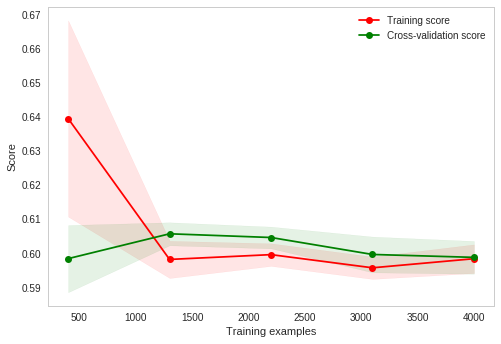

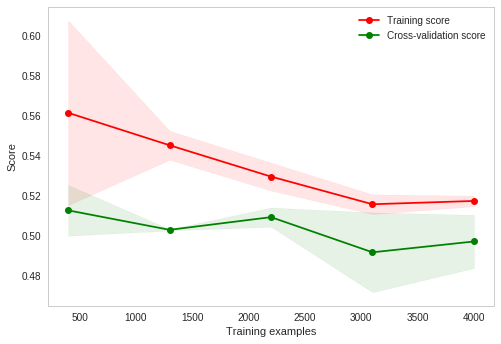

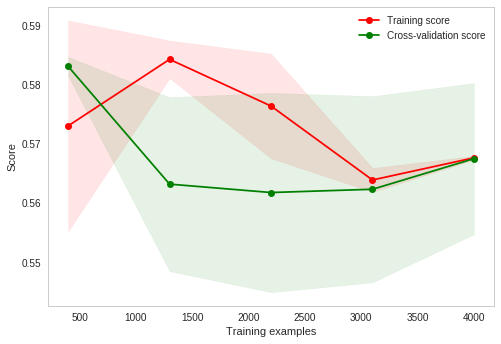

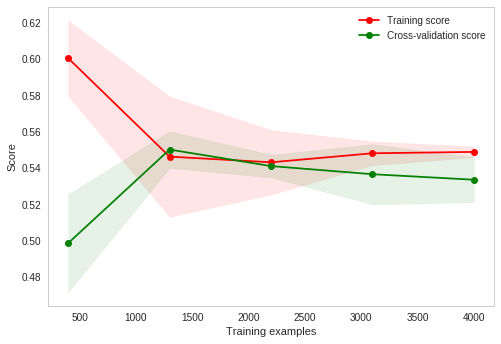

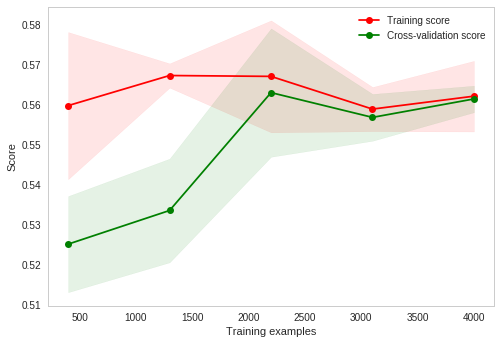

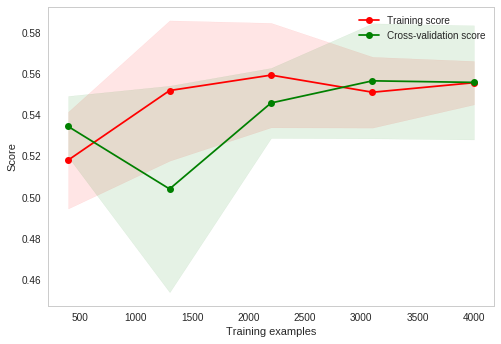

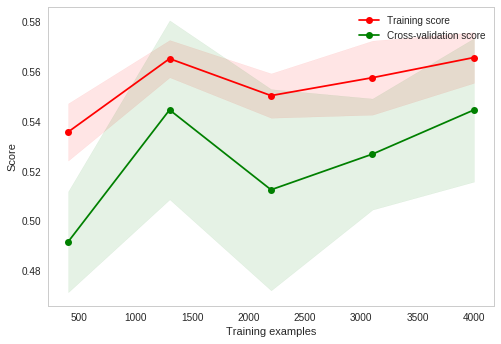

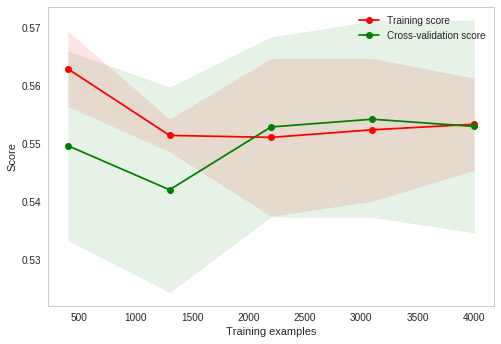

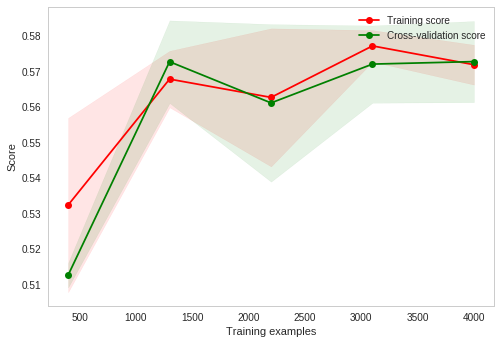

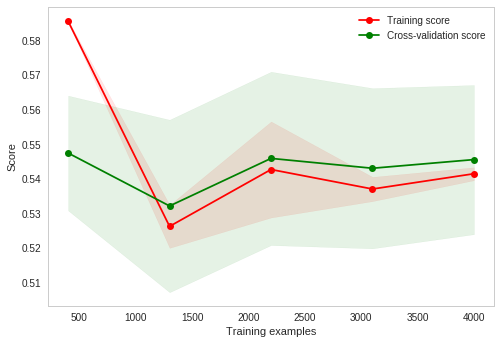

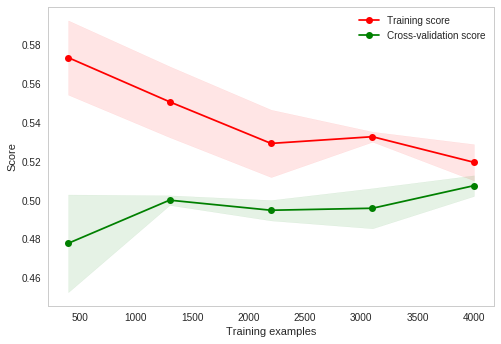

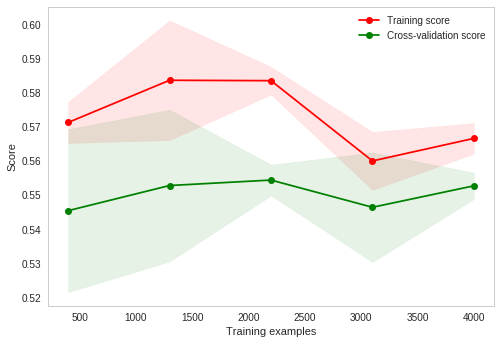

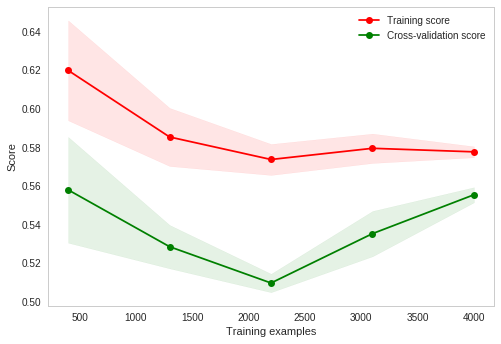

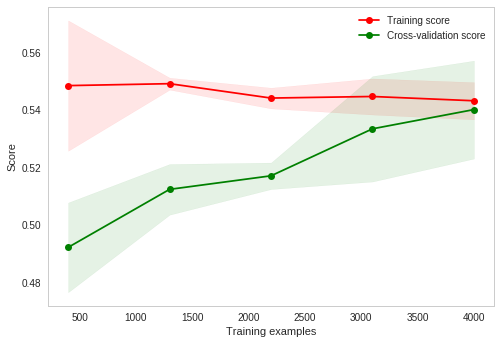

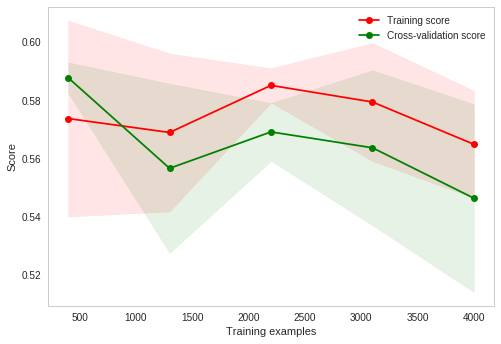

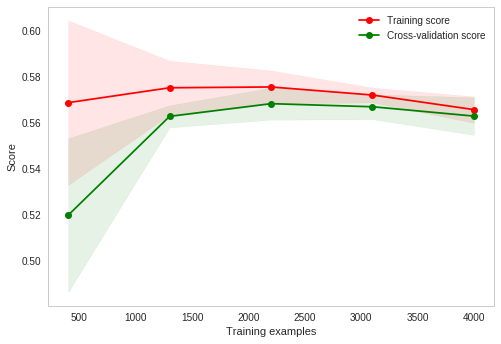

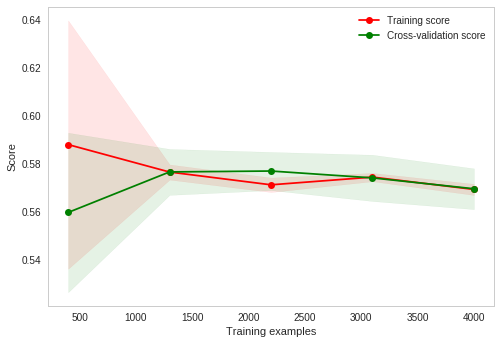

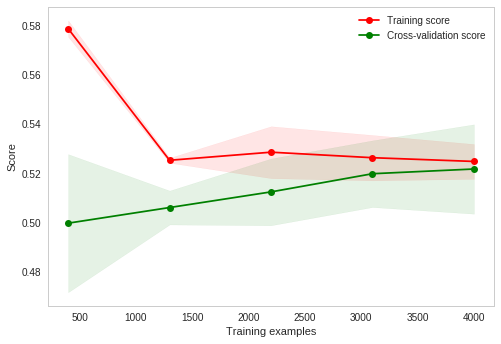

In [22]:
for idx, row in df_overfit[df_overfit['diff_cv_train'] > 0.04].iterrows():
    r = row['r']
    s = row['s']
    stock = idx
    gamma = row['gamma']
    C = row['C']

    df, df_cv, df_test = read_gdf_data(stock, r, s)
    clf = plot_svm_learning_curve(df, C=C, gamma=gamma)

### Validation curve

In [23]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn.svm import SVC
from sklearn.model_selection import validation_curve


def plot_validation_curve(df, c_range, gamma_range, c_start=1, gamma_start=1):
    gdf_columns = ['gdf_' + str(i) for i in range(0, 50)][K1:K2]
    X = df.loc[:, gdf_columns]
    y = df[['mid_price_indicator']].values
    c, r = y.shape
    y = y.reshape(c, )
    y[0] = 0
    train_scores, test_scores = validation_curve(
        SVC(kernel='rbf', C=c_start), X, y, param_name="gamma", param_range=gamma_range, scoring="roc_auc", n_jobs=1)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.title("Validation Curve with SVM")
    plt.xlabel("$\gamma$")
    plt.ylabel("Score")
    plt.ylim(0.0, 1.1)
    lw = 2
    plt.semilogx(gamma_range, train_scores_mean, label="Training score",
                 color="darkorange", lw=lw)
    plt.fill_between(gamma_range, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.2,
                     color="darkorange", lw=lw)
    plt.semilogx(gamma_range, test_scores_mean, label="Cross-validation score",
                 color="navy", lw=lw)
    plt.fill_between(gamma_range, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.2,
                     color="navy", lw=lw)
    
    train_scores, test_scores = validation_curve(
    SVC(kernel='rbf', gamma=gamma_start), X, y, param_name="C", param_range=c_range, scoring="roc_auc", n_jobs=1)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.title("Validation Curve with SVM")
    plt.xlabel("$\gamma$")
    plt.ylabel("Score")
    plt.ylim(0.0, 1.1)
    lw = 2
    plt.semilogx(c_range, train_scores_mean, label="Training score C",
                 color="red", lw=lw)
    plt.fill_between(c_range, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.2,
                     color="red", lw=lw)
    plt.semilogx(c_range, test_scores_mean, label="Cross-validation score C",
                 color="green", lw=lw)
    plt.fill_between(c_range, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.2,
                     color="green", lw=lw)
    
    
    plt.legend(loc="best")

#### 10166

C                100.000000
K                 50.000000
gamma             10.000000
r                  0.070000
roc_cv             0.752252
roc_train          0.610735
s                  0.400000
roc_log_cv         0.546020
roc_log_train      0.561012
cv_train_diff      0.141518
diff_cv_train      0.141518
Name: 10166, dtype: float64


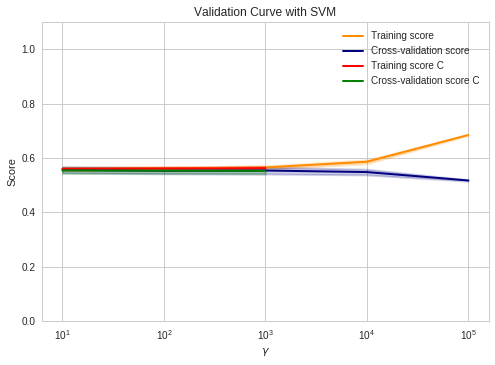

In [24]:
row = df_overfit[df_overfit['diff_cv_train'] > 0.04].loc[10166]
r = 0.01 #row['r']
s = 0.5 #row['s']
stock = 10166
gamma = row['gamma']
C = row['C']
print(row)
df, df_cv, df_test = read_gdf_data(stock, r, s)
plot_validation_curve(df, c_range=np.logspace(1, 3, 5), 
                      gamma_range=np.logspace(1, 5, 5), c_start=100, gamma_start=100)

C                100.000000
K                 50.000000
gamma             10.000000
r                  0.070000
roc_cv             0.752252
roc_train          0.610735
s                  0.400000
roc_log_cv         0.546020
roc_log_train      0.561012
cv_train_diff      0.141518
diff_cv_train      0.141518
Name: 10166, dtype: float64


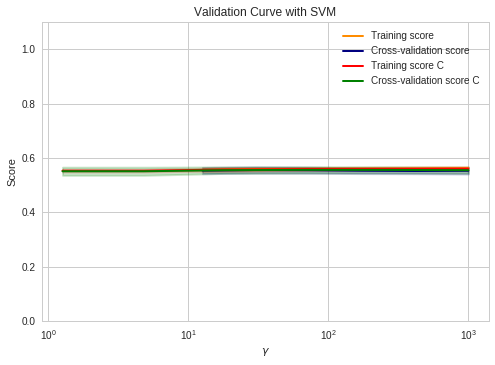

In [25]:
r = 0.01 #row['r']
s = 0.5 #row['s']
stock = 10166
gamma = row['gamma']
C = row['C']
print(row)
df, df_cv, df_test = read_gdf_data(stock, r, s)
plot_validation_curve(df, c_range=np.logspace(0.1, 3, 6), 
                      gamma_range=np.logspace(1.1, 3, 6), c_start=10, gamma_start=10)

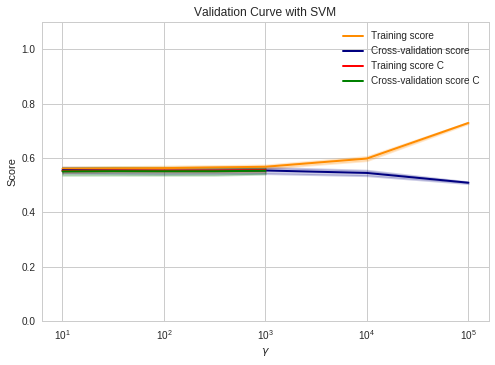

In [26]:
plot_validation_curve(df, c_range=np.logspace(1, 3, 5), 
                      gamma_range=np.logspace(1, 5, 5), c_start=1000, gamma_start=0.1)

SVC(C=0.1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.1, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

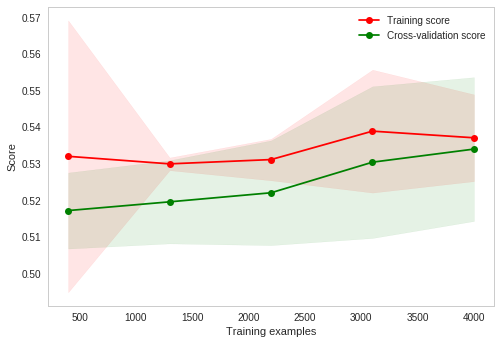

In [27]:
plot_svm_learning_curve(df, C=0.1, gamma=0.1)

In [28]:
df_overfit[df_overfit['diff_cv_train'] > 0.04]

,C,K,gamma,r,roc_cv,roc_train,s,roc_log_cv,roc_log_train,cv_train_diff,diff_cv_train
stock,,,,,,,,,,,
3035,1,50,1,0.10,0.758388,0.626419,0.2,0.549456,0.580671,0.131969,0.131969
10166,100,50,10,0.07,0.752252,0.610735,0.4,0.546020,0.561012,0.141518,0.141518
8080,1,50,10,0.01,0.749248,0.670069,0.1,0.557461,0.577324,0.079179,0.079179
1907,1000,50,1,0.09,0.744612,0.606157,0.5,0.563089,0.535701,0.138454,0.138454
12417,10,50,1,0.09,0.738967,0.608984,0.1,0.574489,0.579153,0.129983,0.129983
11867,10,50,1,0.02,0.738869,0.593297,0.1,0.550629,0.561585,0.145573,0.145573
12255,1,50,10,0.03,0.737619,0.651294,0.5,0.557666,0.574662,0.086325,0.086325
7858,10,50,1,0.03,0.692540,0.613570,0.5,0.585866,0.572104,0.078970,0.078970
5836,10,50,10,0.01,0.674432,0.553565,0.5,0.559765,0.559133,0.120867,0.120867


,C,K,gamma,r,roc_cv,roc_train,s,stock,roc_log_cv,roc_log_train,cv_train_diff
5437,100,50,100,0.01,0.558062,0.547571,0.5,10166,0.54602,0.561012,0.010491


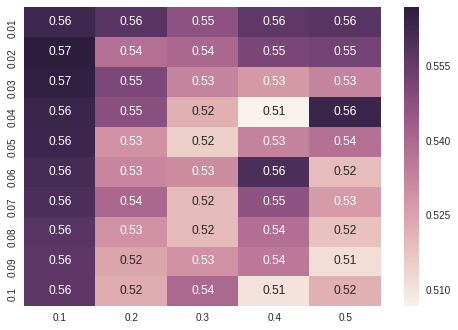

In [29]:
df_res = df_res.sort_values(by='roc_cv', ascending=False)
df_g = pd.DataFrame(index=rr, columns=ss)
for i, row in df_res[df_res['gamma'] == 100][df_res['C'] == 100][df_res['stock'] == 10166].groupby(['r', 's']).first().iterrows():
    if not np.isnan(row['roc_cv']):
        df_g.loc[i[0]][i[1]] = row['roc_cv']
df_g = df_g.apply(pd.to_numeric)      
sns.heatmap(df_g, annot=True)
plt.figure()
df_res[df_res['gamma'] == 100][df_res['C'] == 100][df_res['stock'] == 10166][df_res['r'] == 0.01][df_res['s']==0.5]

,C,K,gamma,r,roc_cv,roc_train,s,stock,roc_log_cv,roc_log_train,cv_train_diff
5437,100,50,100,0.01,0.558062,0.547571,0.5,10166,0.54602,0.561012,0.010491


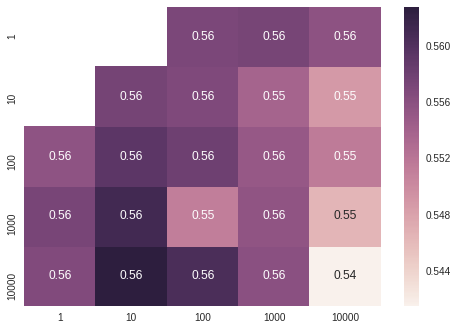

In [30]:
df_res = df_res.sort_values(by='roc_cv', ascending=False)
df_g = pd.DataFrame(index=sorted(df_res['C'].unique()), columns=sorted(df_res['gamma'].unique()))
for i, row in df_res[df_res['s'] == 0.5][df_res['r'] == 0.01][df_res['stock'] == 10166].groupby(['C', 'gamma']).first().iterrows():
    if not np.isnan(row['roc_cv']):
        df_g.loc[i[0]][i[1]] = row['roc_cv']
df_g = df_g.apply(pd.to_numeric)      
sns.heatmap(df_g, annot=True)
plt.figure()
df_res[df_res['gamma'] == 100][df_res['C'] == 100][df_res['stock'] == 10166][df_res['r'] == 0.01][df_res['s']==0.5]

### 9062

In [31]:
stock = 9062

C                100.000000
K                 50.000000
gamma            100.000000
r                  0.010000
roc_cv             0.542794
roc_train          0.540283
s                  0.100000
roc_log_cv         0.552745
roc_log_train      0.533872
cv_train_diff      0.002511
diff_cv_train      0.002511
Name: 9062, dtype: float64


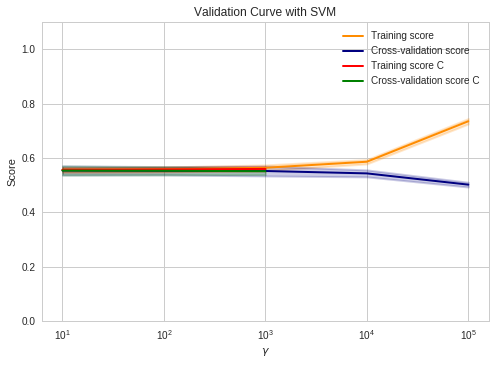

In [32]:
row = df_overfit.loc[stock]
r = row['r']
s = row['s']
gamma = row['gamma']
C = row['C']
print(row)
df, df_cv, df_test = read_gdf_data(stock, r, s)
plot_validation_curve(df, c_range=np.logspace(1, 3, 5), 
                      gamma_range=np.logspace(1, 5, 5), c_start=100, gamma_start=100)